In [44]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen

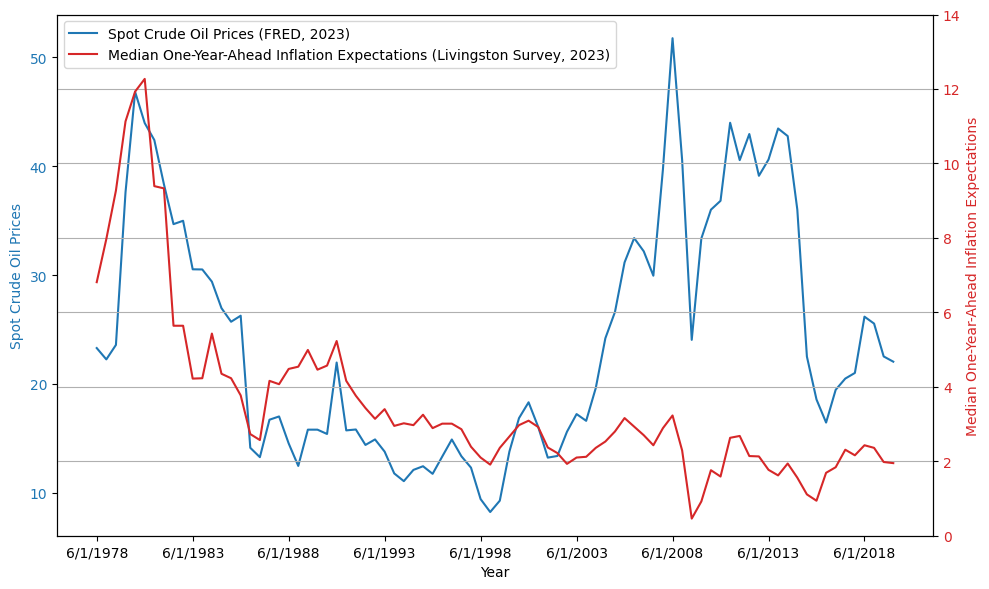

In [53]:
# Input the csv data
data = pd.read_csv("final data.csv")

years = data['Date']
inflation_expectations = data['Inflation Expectations']
oil_prices = data['Oil Prices']

# Plot oil prices on the left y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(years, oil_prices, color='tab:blue', label='Spot Crude Oil Prices (FRED, 2023)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Spot Crude Oil Prices', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot inflation expectations on the right y-axis
ax2 = ax1.twinx()


ax2.plot(years, inflation_expectations, color='tab:red', 
         label='Median One-Year-Ahead Inflation Expectations (Livingston Survey, 2023)')
ax2.set_ylabel('Median One-Year-Ahead Inflation Expectations', color='tab:red')
ax2.set_ylim(0, 14)  
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.xticks(np.arange(0, len(years), 10))

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid(True)
plt.tight_layout()
# plt.savefig('oil.png', dpi = 300)

In [56]:
# ADF for oil prices, trend
adftest = adfuller(oil_prices, autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -1.801282761393759
P-Value: 0.7041394595296644
Number of lags: 2
Number of observations: 81
Critical Values: {'1%': -4.075121979053178, '5%': -3.4661550774027594, '10%': -3.1596113315495042}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [57]:
# ADF for oil prices, no trend
adftest = adfuller(oil_prices, autolag='AIC', regression='c')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -1.8006902686389765
P-Value: 0.38011904827839427
Number of lags: 2
Number of observations: 81
Critical Values: {'1%': -3.5137900174243235, '5%': -2.8979433868293945, '10%': -2.5861907285474777}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [58]:
# ADF for inflation expectations, trend
adftest = adfuller(inflation_expectations, autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.608538762833604
P-Value: 0.2759778805959765
Number of lags: 1
Number of observations: 82
Critical Values: {'1%': -4.073644812103713, '5%': -3.46545759986071, '10%': -3.1592060271905518}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [59]:
# ADF for inflation expectations, no trend
adftest = adfuller(inflation_expectations, autolag='AIC', regression='c')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -1.770639694719193
P-Value: 0.39513258107370186
Number of lags: 0
Number of observations: 83
Critical Values: {'1%': -3.5117123057187376, '5%': -2.8970475206326833, '10%': -2.5857126912469153}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [60]:
# ADF for differentiated oil prices, trend
oil_prices_diff = data['Oil prices'].diff().dropna()

adftest_diff = adfuller(oil_prices_diff, autolag='AIC', regression='ct')
print("ADF Statistic:", adftest_diff[0])
print("p-value:", adftest_diff[1])
print("Critical Values:", adftest_diff[4])

KeyError: 'Oil prices'

In [ ]:
# ADF for differentiated oil prices, no trend
oil_prices_diff = data['Oil prices'].diff().dropna()

adftest_diff = adfuller(oil_prices_diff, autolag='AIC', regression='c')
print("ADF Statistic:", adftest_diff[0])
print("p-value:", adftest_diff[1])
print("Critical Values:", adftest_diff[4])

In [ ]:
# ADF for differentiated inflation expectations, trend
inflation_expectations_diff = data['Inflation expectations'].diff().dropna()

adftest_diff = adfuller(inflation_expectations_diff, autolag='AIC', regression='ct')
print("ADF Statistic:", adftest_diff[0])
print("p-value:", adftest_diff[1])
print("Critical Values:", adftest_diff[4])

In [ ]:
# ADF for differentiated inflation expectations, no trend
inflation_expectations_diff = data['Inflation expectations'].diff().dropna()

adftest_diff = adfuller(inflation_expectations_diff, autolag='AIC', regression='c')
print("ADF Statistic:", adftest_diff[0])
print("p-value:", adftest_diff[1])
print("Critical Values:", adftest_diff[4])

In [ ]:
inflation_pp_test = PhillipsPerron(data['Inflation expectations'], trend = 'ct')
inflation_pp_test.summary()

In [ ]:
# PP test for inflation expectations, trend
oil_pp_test = PhillipsPerron(data['Inflation expectations'], trend = 'ct')
oil_pp_test.summary()

In [61]:
# PP test for inflation expectations, no trend
oil_pp_test = PhillipsPerron(data['Inflation expectations'], trend = 'c')
oil_pp_test.summary()

KeyError: 'Inflation expectations'

In [62]:
# PP test for oil prices, trend
oil_pp_test = PhillipsPerron(data['Oil prices'], trend = 'ct')
oil_pp_test.summary()

KeyError: 'Oil prices'

In [63]:
# PP test for oil prices, no trend
oil_pp_test = PhillipsPerron(data['Oil prices'], trend = 'c')
oil_pp_test.summary()

KeyError: 'Oil prices'

In [64]:
# PP test for differentiated inflation expectations, no trend
oil_pp_test = PhillipsPerron(inflation_expectations_diff, trend = 'c')
oil_pp_test.summary()

Test Statistic,-5.380
P-value,0.000
Lags,10


In [65]:
# PP test for differentiated inflation expectations, trend
oil_pp_test = PhillipsPerron(inflation_expectations_diff, trend = 'ct')
oil_pp_test.summary()

Test Statistic,-6.021
P-value,0.000
Lags,10


In [66]:
# PP test for differentiated oil prices, no trend
inflation_pp_test = PhillipsPerron(oil_prices_diff, trend = 'c')
inflation_pp_test.summary()

Test Statistic,-6.146
P-value,0.000
Lags,10


In [67]:
# PP test for differentiated oil prices, trend
inflation_pp_test = PhillipsPerron(oil_prices_diff, trend = 'ct')
inflation_pp_test.summary()

Test Statistic,-6.142
P-value,0.000
Lags,10


In [68]:
print(type(inflation_expectations_diff))

<class 'pandas.core.series.Series'>


In [69]:
df = pd.DataFrame({
    'inflation_expectations_diff': inflation_expectations_diff,
    'oil_prices_diff': oil_prices_diff
})

# Perform Johansen cointegration test
result = coint_johansen(df, det_order=0, k_ar_diff=1)

# Print the results
print("Eigenvalues:")
print(result.eig)
print("\nTrace statistic:")
print(result.lr1)
print("\nCritical values (90%, 95%, 99%):")
print(result.cvt)
print("\nEigen statistic:")
print(result.lr2)
print("\nCritical values (90%, 95%, 99%):")
print(result.cvm)

Eigenvalues:
[0.57696138 0.38956906]

Trace statistic:
[43.32422149 15.79488342]

Critical values (90%, 95%, 99%):
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Eigen statistic:
[27.52933808 15.79488342]

Critical values (90%, 95%, 99%):
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [70]:
print(result.trace_stat)

[43.32422149 15.79488342]


In [71]:
print(result.trace_stat_crit_vals)

[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


In [72]:
df = pd.DataFrame({
    'inflation_expectations_diff': inflation_expectations_diff[:24],
    'oil_prices_diff': oil_prices_diff[:24]
})

# Perform Johansen cointegration test
result = coint_johansen(df, det_order=0, k_ar_diff=1)

# Print the results
print("Eigenvalues:")
print(result.eig)
print("\nTrace statistic:")
print(result.lr1)
print("\nCritical values (90%, 95%, 99%):")
print(result.cvt)
print("\nEigen statistic:")
print(result.lr2)
print("\nCritical values (90%, 95%, 99%):")
print(result.cvm)

Eigenvalues:
[0.62872066 0.35836064]

Trace statistic:
[31.55964802  9.76203547]

Critical values (90%, 95%, 99%):
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Eigen statistic:
[21.79761255  9.76203547]

Critical values (90%, 95%, 99%):
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [73]:
df = pd.DataFrame({
    'inflation_expectations_diff': inflation_expectations_diff[24:],
    'oil_prices_diff': oil_prices_diff[24:]
})

# Perform Johansen cointegration test
result = coint_johansen(df, det_order=0, k_ar_diff=1)

# Print the results
print("Eigenvalues:")
print(result.eig)
print("\nTrace statistic:")
print(result.lr1)
print("\nCritical values (90%, 95%, 99%):")
print(result.cvt)
print("\nEigen statistic:")
print(result.lr2)
print("\nCritical values (90%, 95%, 99%):")
print(result.cvm)

Eigenvalues:
[0.95890471 0.43553329]

Trace statistic:
[30.10988572  4.57499101]

Critical values (90%, 95%, 99%):
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Eigen statistic:
[25.53489471  4.57499101]

Critical values (90%, 95%, 99%):
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [74]:
for index in range(31):
    df = pd.DataFrame({
        'inflation_expectations_diff': inflation_expectations_diff[index:],
        'oil_prices_diff': oil_prices_diff[index:]
    })

    # Perform Johansen cointegration test
    result = coint_johansen(df, det_order=0, k_ar_diff=1)

    # Print the results
    print("\nTrace statistic:")
    print(index, ":", result.lr1)

    print("\nEigen statistic:")
    print(index, ":", result.lr2)


Trace statistic:
0 : [43.32422149 15.79488342]

Eigen statistic:
0 : [27.52933808 15.79488342]

Trace statistic:
1 : [42.48045933 15.5248842 ]

Eigen statistic:
1 : [26.95557513 15.5248842 ]

Trace statistic:
2 : [39.09418336 15.60708082]

Eigen statistic:
2 : [23.48710255 15.60708082]

Trace statistic:
3 : [36.62746531 13.90317039]

Eigen statistic:
3 : [22.72429492 13.90317039]

Trace statistic:
4 : [43.38795585 13.19138214]

Eigen statistic:
4 : [30.19657371 13.19138214]

Trace statistic:
5 : [44.46096967 12.73452504]

Eigen statistic:
5 : [31.72644463 12.73452504]

Trace statistic:
6 : [34.93130465 12.17498622]

Eigen statistic:
6 : [22.75631842 12.17498622]

Trace statistic:
7 : [40.68081222 11.70744106]

Eigen statistic:
7 : [28.97337115 11.70744106]

Trace statistic:
8 : [41.01408277 11.78077621]

Eigen statistic:
8 : [29.23330656 11.78077621]

Trace statistic:
9 : [29.6801559  11.13674487]

Eigen statistic:
9 : [18.54341103 11.13674487]

Trace statistic:
10 : [33.12499643 10.6

C:\Users\86189\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\vector_ar\vecm.py:731: RuntimeWarning: invalid value encountered in log
  tmp = np.log(iota - a)[i:]
C:\Users\86189\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\vector_ar\vecm.py:733: RuntimeWarning: invalid value encountered in log
  lr2[i] = -t * np.log(1 - a[i])


LinAlgError: Matrix is not positive definite